# **Algoritma Pemilihan Bully – Visualisasi Animasi Interaktif**

- **Author:** `Rozhak`
- **Version:** `1.0`
- **Pembaruan:** `18 Oktober 2025`

## **1. Mengimpor Pustaka yang Diperlukan**

Bagian ini mengimpor pustaka yang diperlukan untuk menjalankan simulasi dan visualisasi animasi Algoritma Bully. Pustaka utama mencangkup `matplotlib` untuk visualisasi, `math` untuk perhitungan geometri, dan `IPython.display.HTML` untuk menampilkan animasi di lingkungan notebook.

In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
from IPython.display import HTML

## **2. Konfigurasi Parameter Simulasi**

Bagian ini didefinisikan parameter dasat simulasi, seperti jumlah node, radius penemparan node dalam lingkaran, ukuran node, kecepatan animasi (FPS), dan durasi total animasi. Selain itu, skenario kejadian (seperti crach dan pertukaran pesan) juga ditentukan secara eksplisit untuk memandu alur animasi.

In [ ]:
JUM_NODE = 5
ID_NODE = list(range(1, JUM_NODE + 1))
RADIUS = 3.0
UKURAN_NODE = 600
FPS = 30
DURASI_DETIK = 12

KEJADIAN = [
    (0.5, None, 5, 'CRASH'),
    (1.0, 2, 3, 'PEMILIHAN'),
    (1.0, 2, 4, 'PEMILIHAN'),
    (1.0, 2, 5, 'PEMILIHAN'),
    (1.6, 3, 2, 'OK'),
    (1.6, 4, 2, 'OK'),
    (2.2, 3, 4, 'PEMILIHAN'),
    (2.2, 3, 5, 'PEMILIHAN'),
    (2.8, 4, 3, 'OK'),
    (3.4, 4, 5, 'PEMILIHAN'),
    (4.2, 4, 1, 'KOORDINATOR'),
    (4.2, 4, 2, 'KOORDINATOR'),
    (4.2, 4, 3, 'KOORDINATOR'),
    (4.2, 4, 5, 'KOORDINATOR')
]

TOTAL_FRAME = DURASI_DETIK * FPS

def waktu_ke_frame(t):
    return int(t * FPS)

KEJADIAN_FRAME = [(waktu_ke_frame(e[0]), e[1], e[2], e[3]) for e in KEJADIAN]

## **3. Penempatan Node dalam Lingkungan**

Setiap node ditempatkan secara merata pada keliling lingkaran menggunakan koordinat polar. Posisi ini digunakan untuk menentukan lokasi visual setiap node selama animasi.

In [ ]:
posisi = {}
for i, nid in enumerate(ID_NODE):
        sudut = 2 * math.pi * i / JUM_NODE
        x = RADIUS * math.cos(sudut)
        y = RADIUS * math.sin(sudut)
        posisi[nid] = (x, y)

## **4. Inisialisasi Status dan Logika Animasi**

Status awal setiap node (aktif, crash, atau koordinator) diinisialisasi. Warna node digunakan sebagai indikator visual: abu-abu untuk aktif, merah muda untuk crash, dan hijau muda untuk koordinator. Selain itu, struktur data juga melacak pesan yang sedang dalam perjalanan dan log teks juga disiapkan.

In [ ]:
warna_node = {nid: 'lightgrey' for nid in ID_NODE}
node_crash = set()
koordinator = None
pesan_terbang = []
baris_log = []
MAKS_BARIS_LOG = 6

def tambah_log(teks):
    baris_log.insert(0, teks)
    while len(baris_log) > MAKS_BARIS_LOG:
        baris_log.pop()

def mulai_kirim_pesan(dari, ke, pesan, frame_sekarang):
    x1, y1 = posisi[dari]
    x2, y2 = posisi[ke]

    jarak = math.hypot(x2 - x1, y2 - y1)
    durasi_dasar = int(FPS * 0.6)
    frame_perjalanan = max(4, int(durasi_dasar * (1 + jarak / (RADIUS * 2))))

    pesan_terbang.append({
        'dari': dari,
        'ke': ke,
        'pesan': pesan,
        'mulai': frame_sekarang,
        'selesai': frame_sekarang + frame_perjalanan
    })

## **5. Persiapan Visualisasi dengan `Matplotlib`**

Lingkungan visualisasi dibangun menggunakan `matplotlib`. Setiap node direpresentasikan sebagai lingkungan dengan label, dan pesan yang dikirim ditampilkan sebagai simbol bergerak antar node. Kotak log ditempatkan di bagian bawah untuk menampilkan riwayat secara real-time.

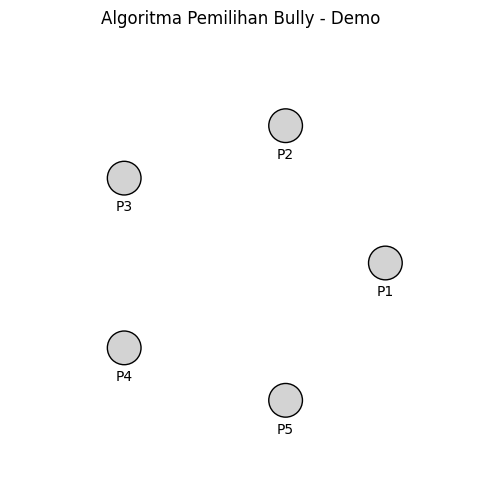

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-RADIUS * 1.6, RADIUS * 1.6)
ax.set_ylim(-RADIUS * 1.6, RADIUS * 1.6)
ax.set_aspect('equal')
ax.axis('off')
plt.title('Algoritma Pemilihan Bully - Demo')

artist_label = {}
artist_node = {}
for nid, (x, y) in posisi.items():
    c = Circle((x, y), 0.35, facecolor=warna_node[nid], edgecolor='black', zorder=2)
    ax.add_patch(c)
    artist_node[nid] = c
    lbl = ax.text(x, y - 0.6, f'P{nid}', ha='center', va='center', fontsize=10)
    artist_label[nid] = lbl

artist_pesan = []
for _ in range(10):
    p, = ax.plot([], [], marker='o', markersize=8, alpha=0.9)
    artist_pesan.append(p)

teks_log = ax.text(-RADIUS * 1.5, -RADIUS * 1.35, '', ha='left', va='top', fontsize=9, family='monospace')
idx_kejadian_frame = 0

## **6. Fungsi Update Animasi**

Fungsi ini dipanggil setiap frame untuk memperbarui status simulasi: memproses kejadian terjadwal, menggerakan pesan antar node, memperbarui warna node sesuai status, dan menampilkan log aktivitas terbaru.

In [ ]:
def update(frame):
    global idx_kejadian_frame, koordinator
    while idx_kejadian_frame < len(KEJADIAN_FRAME) and KEJADIAN_FRAME[idx_kejadian_frame][0] <= frame:
        _, dari, ke, pesan = KEJADIAN_FRAME[idx_kejadian_frame]
        idx_kejadian_frame += 1

        if pesan == 'CRASH' and ke is not None:
            node_crash.add(ke)
            warna_node[ke] = 'lightcoral'
            artist_node[ke].set_facecolor(warna_node[ke])
            tambah_log(f'P{ke} mengalami crash')
        elif pesan == 'PEMILIHAN':
            if dari is not None and ke is not None:
                tambah_log(f'P{dari} -> P{ke}: PEMILIHAN')
                mulai_kirim_pesan(dari, ke, 'PEMILIHAN', frame)
        elif pesan == 'OK':
            tambah_log(f'P{dari} -> P{ke}: OK')
            mulai_kirim_pesan(dari, ke, 'OK', frame)
        elif pesan == 'KOORDINATOR':
            tambah_log(f'P{dari} mengumumkan KOORDINATOR ke P{ke}')
            mulai_kirim_pesan(dari, ke, 'KOORDINATOR', frame)

    for p in artist_pesan:
        p.set_data([], [])
        p.set_marker('o')

    idx_artist = 0
    for msg in list(pesan_terbang):
        frame_mulai = msg['mulai']
        frame_selesai = msg['selesai']
        if frame < frame_mulai:
            continue

        t = (frame - frame_mulai) / max(1, (frame_selesai - frame_mulai))
        if t >= 1.0:
            if msg['pesan'] == 'KOORDINATOR':
                koordinator = msg['dari']
                for nid in ID_NODE:
                    if nid not in node_crash:
                        warna_node[nid] = 'lightgreen' if nid == koordinator else 'lightgrey'
                        artist_node[nid].set_facecolor(warna_node[nid])
                tambah_log(f'P{msg["dari"]} -> P{msg["ke"]}: KOORDINATOR terkirim')
            elif msg['pesan'] == 'PEMILIHAN':
                rid = msg['ke']
                if rid not in node_crash and rid > msg['dari']:
                    mulai_kirim_pesan(rid, msg['dari'], 'OK', frame)
                tambah_log(f'P{msg["dari"]} -> P{msg["ke"]}: PEMILIHAN terkirim')
            elif msg['pesan'] == 'OK':
                tambah_log(f'P{msg["dari"]} -> P{msg["ke"]}: OK terkirim')
            pesan_terbang.remove(msg)
            continue

        x1, y1 = posisi[msg['dari']]
        x2, y2 = posisi[msg['ke']]
        xm = x1 + (x2 - x1) * t
        ym = y1 + (y2 - y1) * t

        if idx_artist < len(artist_pesan):
            p = artist_pesan[idx_artist]
            if msg['pesan'] == 'PEMILIHAN':
                p.set_marker('^')
                p.set_markersize(8)
            elif msg['pesan'] == 'OK':
                p.set_marker('s')
                p.set_markersize(6)
            elif msg['pesan'] == 'KOORDINATOR':
                p.set_marker('*')
                p.set_markersize(10)
            p.set_data([xm], [ym])
            idx_artist += 1

    teks_log.set_text('\n'.join(baris_log))
    return list(artist_node.values()) + artist_pesan + [teks_log]

## **7. Menjalankan dan Menampilkan Animasi**

Animasi dijalankan menggunakan `FuncAnimation` dadi `matplotlib` dan ditampilkan sebagai HTML interaktif dilingkungan notebook seperti **Google Colab**. Figure statis ditutup agar tidak mengganggu tampilan output.

In [ ]:
ani = animation.FuncAnimation(fig, update, frames=TOTAL_FRAME, interval=1000 / FPS, blit=False)
plt.close(fig)
display(HTML(ani.to_jshtml()))

#display(HTML(ani.to_html5_video()))
ani.save('bully-sim.mp4')